In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pe
import build_data
from build_data import ext_pyomo_vals
import model as m
import seaborn as sns
import pandas as pd
import os
import dotenv
import sys
import mysql.connector
import matplotlib.ticker as ticker


In [2]:
# Set up variables
_import_factor = 400 # -> increase the maximum import capacity
_stor_factor = 600 # -> increase the storage capacity
_specific_date='2019-11-06' # -> Change date
_time_step = 60 # -> Change time step
_update_forecast = False # -> True to have forecast updat in the operation
_save_plots = True # -> True to save the plots

#Comentarios sobre performance de dias
#Dia 6 corre rapido
#ao fim do dia 13 as previsões sao maiores do q o consumo real
#dia 16/17 é um exemplo de uma pessima previsão

In [3]:
conf = dotenv.dotenv_values()
path_to_solver = conf["PATH_TO_SOLVER"]

In [4]:
project_colors = {"green": "#58c1ae", "blue": "#0e73b9", "lightgreen": "#cdd451",
                  "babyblue": "#5ebcea", "orange": "#e58033", "yellow": "#eacf5e",
                  "raw": "#ece9d6"}
project_colors_list = ["#58c1ae", "#0e73b9", "#cdd451", "#5ebcea", "#e58033","#eacf5e","#ece9d6"] 

# Step 1 - Forecast:

In [5]:
#Build forecast data

# Create data object -> This object, iniatially, will store all the data from the excel:
Data_forecast = build_data.Data() 

# Function to change the timestep. 
Data_forecast.change_time_step(_time_step) 

step1_folder = './inputs_database/no_factors/step1'
# As said before, initially the object Data_forecast only stores what comes from Excel.
# These two functions replace the data from excel by the data from the Mysql FORECAST Databases:
# All the values in those that bases come in W.
Data_forecast.get_gen_forecast_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, experiment_id = 17, time_step=_time_step, folder=step1_folder)
Data_forecast.get_loads_forecast_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, experiment_id = 23, time_step=_time_step, folder=step1_folder)

print("(#CS, #VE, #Time-Steps) -> ", Data_forecast.get_data().vehicle['schedule_cs_usage'].shape)


(#CS, #VE, #Time-Steps) ->  (4, 7, 24)


## Number of loads and generators:

In [6]:
# Number of houses:
print(f"Number of loads: {Data_forecast.get_data().load['p_forecast'].shape[0]}")

# Number of generators:

print(f"Number of generators: {Data_forecast.get_data().generator['p_forecast'].shape[0]}")

#print(Data_forecast.get_data().charging_station["p_charge_limit"])
#print(Data_forecast.get_data().charging_station.keys())

Number of loads: 5
Number of generators: 5


In [7]:
# Create the model for the forecast
model_forecast = m.creat_model(Data_forecast.get_data(), end = 24*60//_time_step+1)

# Define the model objects which object has parameters, variables and constraints.
model_forecast = m.def_import_export(Data_forecast.get_data(), model_forecast) #From Excel.
model_forecast = m.def_gen(Data_forecast.get_data(), model_forecast) #It can come from Excel or DB.
model_forecast = m.def_loads(Data_forecast.get_data(), model_forecast) #It can come from Excel or DB.
model_forecast = m.def_storage(Data_forecast.get_data(), model_forecast) #From Excel.
model_forecast = m.def_v2g(Data_forecast.get_data(), model_forecast) #From Excel.
model_forecast = m.def_charging_stations(Data_forecast.get_data(), model_forecast) #From Excel.

#Define the balance and objective function
model_forecast.balanceEq = pe.Constraint(model_forecast.t, rule=m._balanceEq,
                                doc='Balance equation')

model_forecast.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                           doc='Objective function')

model_forecast.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver_forecast = pe.SolverFactory('cplex', executable=path_to_solver)
solver_forecast.options['LogFile'] = 'res_community.log'

results_forecast = solver_forecast.solve(model_forecast)
# results_forecast.write()
objective_value = pe.value(model_forecast.objFn)
print(f"The value of the objective function is: {objective_value}")



The value of the objective function is: 68.72924046774607


In [8]:
#  Result extraction - Saving the results on CSVs:
folder = './results/no_factors/step1'

if not os.path.exists(folder):
    os.makedirs(folder)

# Generation
if not os.path.exists(folder + '/generation/'):
    os.makedirs(folder + '/generation/')

result_genActPower = ext_pyomo_vals(model_forecast.genActPower)
result_genActPower.to_csv(folder + '/generation/result_genActPower.csv')

result_genExcActPower = ext_pyomo_vals(model_forecast.genExcPower)
result_genExcActPower.to_csv(folder + '/generation/result_genExcActPower.csv')

# Imports/Exports
if not os.path.exists(folder + '/power/'):
    os.makedirs(folder + '/power/')

result_pimp= ext_pyomo_vals(model_forecast.imports)
result_pimp.to_csv(folder + '/power/result_pimp.csv')

result_pexp = ext_pyomo_vals(model_forecast.exports)
result_pexp.to_csv(folder + '/power/result_pexp.csv')

# Loads
if not os.path.exists(folder + '/loads/'):
    os.makedirs(folder + '/loads/')

result_loadRedActPower = ext_pyomo_vals(model_forecast.loadRedActPower)
result_loadRedActPower.to_csv(folder + '/loads/result_loadRedActPower.csv')

result_loadCutActPower = ext_pyomo_vals(model_forecast.loadCutActPower)
result_loadCutActPower.to_csv(folder + '/loads/result_loadCutActPower.csv')

result_loadENS = ext_pyomo_vals(model_forecast.loadENS)
result_loadENS.to_csv(folder + '/loads/result_loadENS.csv')

# Storage
if not os.path.exists(folder + '/storage/'):
    os.makedirs(folder + '/storage/')
    
result_storDchActPower = ext_pyomo_vals(model_forecast.storDischarge)
result_storDchActPower.to_csv(folder + '/storage/result_storDchActPower.csv')

result_storChActPower = ext_pyomo_vals(model_forecast.storCharge)
result_storChActPower.to_csv(folder + '/storage/result_storChActPower.csv')

result_storEnerState = ext_pyomo_vals(model_forecast.storState)
result_storEnerState.to_csv(folder + '/storage/result_storEnerState.csv')

result_storRelax = ext_pyomo_vals(model_forecast.storRelax)
result_storRelax.to_csv(folder + '/storage/result_storRelax.csv')

result_storScheduleChRelax = ext_pyomo_vals(model_forecast.storScheduleChRelax)
result_storScheduleChRelax.to_csv(folder + '/storage/result_storScheduleChRelax.csv')

result_storScheduleDchRelax = ext_pyomo_vals(model_forecast.storScheduleDchRelax)
result_storScheduleDchRelax.to_csv(folder + '/storage/result_storScheduleDchRelax.csv')

# V2G
if not os.path.exists(folder + '/v2g/'):
    os.makedirs(folder + '/v2g/')
    
result_v2gDchActPower = ext_pyomo_vals(model_forecast.v2gDischarge)
result_v2gDchActPower.to_csv(folder + '/v2g/result_v2gDchActPower.csv')

result_v2gChActPower = ext_pyomo_vals(model_forecast.v2gCharge)
result_v2gChActPower.to_csv(folder + '/v2g/result_v2gChActPower.csv')

result_v2gEnerState = ext_pyomo_vals(model_forecast.v2gState)
result_v2gEnerState.to_csv(folder + '/v2g/result_v2gEnerState.csv')

result_v2gRelax = ext_pyomo_vals(model_forecast.v2gRelax)
result_v2gRelax.to_csv(folder + '/v2g/result_v2gRelax.csv')

result_v2gScheduleChRelax = ext_pyomo_vals(model_forecast.v2gScheduleChRelax)
result_v2gScheduleChRelax.to_csv(folder + '/v2g/result_v2gScheduleChRelax.csv')

result_v2gScheduleDchRelax = ext_pyomo_vals(model_forecast.v2gScheduleDchRelax)
result_v2gScheduleDchRelax.to_csv(folder + '/v2g/result_v2gScheduleDchRelax.csv')

result_v2gScheduleDepartureSOC = ext_pyomo_vals(model_forecast.v2gScheduleDepartureSOC)
result_v2gScheduleDepartureSOC.to_csv(folder + '/v2g/result_v2gScheduleDepartureSOC.csv')

result_v2gSchedule = ext_pyomo_vals(model_forecast.v2gSchedule)
result_v2gSchedule.to_csv(folder + '/v2g/result_v2gSchedule.csv')

result_v2gState = ext_pyomo_vals(model_forecast.v2gState)
result_v2gState.to_csv(folder + '/v2g/result_v2gState.csv')

# Charging Stations
if not os.path.exists(folder + '/cs/'):
    os.makedirs(folder + '/cs/')
   
result_csActPower = ext_pyomo_vals(model_forecast.csCharge)
result_csActPower.to_csv(folder + '/cs/result_csActPower.csv')

result_csActPowerNet = ext_pyomo_vals(model_forecast.csNetCharge)
result_csActPowerNet.to_csv(folder + '/cs/result_csActPowerNet.csv')


# Booleans
if not os.path.exists(folder + '/bool/'):
    os.makedirs(folder + '/bool/')
 
result_genXo = ext_pyomo_vals(model_forecast.genXo)
result_genXo.to_csv(folder + '/bool/result_genXo.csv')

result_loadXo = ext_pyomo_vals(model_forecast.loadXo)
result_loadXo.to_csv(folder + '/bool/result_loadXo.csv')

result_storDchXo = ext_pyomo_vals(model_forecast.storDchXo)
result_storDchXo.to_csv(folder + '/bool/result_storDchXo.csv')

result_storChXo = ext_pyomo_vals(model_forecast.storChXo)
result_storChXo.to_csv(folder + '/bool/result_storChXo.csv')

result_v2gDchXo= ext_pyomo_vals(model_forecast.v2gDchXo)
result_v2gDchXo.to_csv(folder + '/bool/result_v2gDchXo.csv')

result_v2gChXo = ext_pyomo_vals(model_forecast.v2gChXo)
result_v2gChXo.to_csv(folder + '/bool/result_v2gChXo.csv')

In [9]:
with pd.ExcelWriter(folder + '/evs_output.xlsx') as writer:
    result_v2gState.to_excel(writer, sheet_name='v2gState', index=False)
    result_v2gScheduleDepartureSOC.to_excel(writer, sheet_name='v2gScheduleDepartureSOC', index=False)
    result_v2gRelax.to_excel(writer, sheet_name='v2gRelax', index=False)


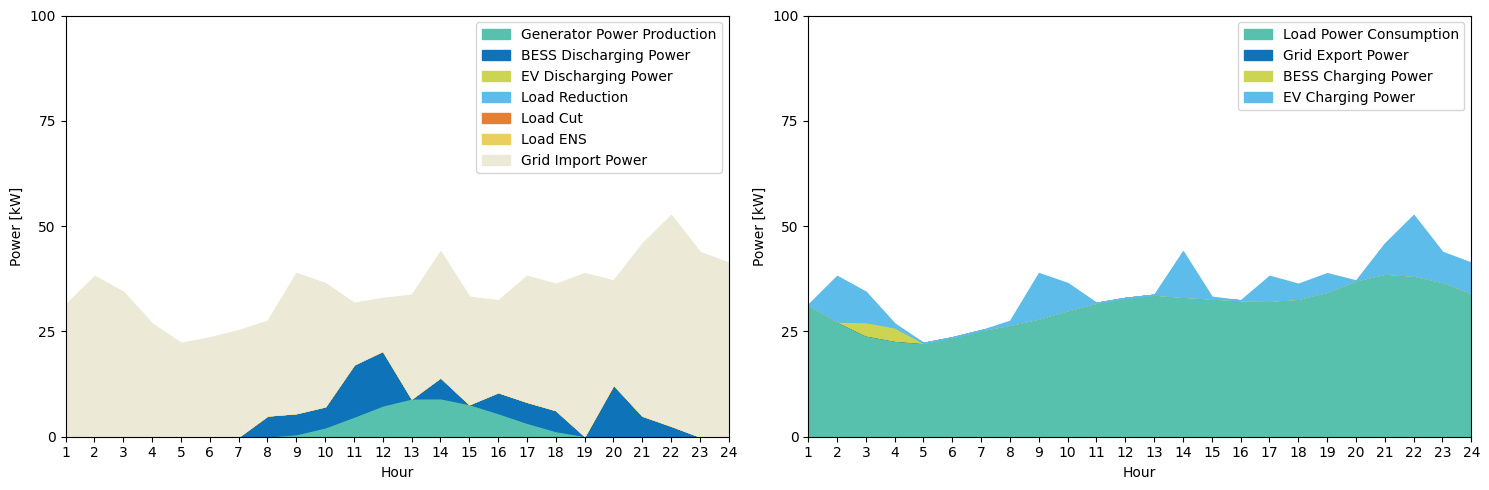

In [10]:
m.plot_profile(result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    model_forecast,
    Data_forecast,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    save = _save_plots, path=f'plots/no_factors/step1/', name = f'forecast-{_specific_date}-step-{_time_step}', graph_max=100, graph_step=25)

In [11]:
# This function put on a excel all the data that was ploted on the previous part (plot_profile function)
m.export_profile_to_excel(
    result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    model_forecast,
    Data_forecast,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    path='./results/no_factors/step1',  
    name='step1_profile_data.xlsx'   
)

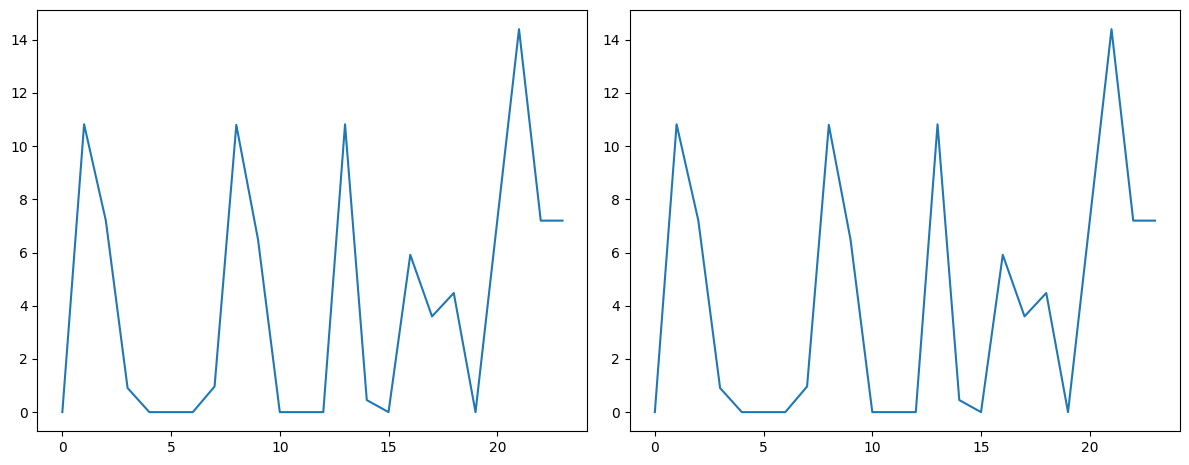

In [12]:
# PLot the results of the eletric vehicles and charging stations
if result_v2gEnerState.values.shape[0] == 5:
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 10))

    for i in range(result_csActPower.values.shape[0]):
        axs[i, 0].plot(result_csActPower.values[i])
        axs[i, 0].set_title(f'Charging Station {i+1}')
        axs[i, 0].set_ylabel('Power [kW]')
        axs[i, 0].set_xlabel('Time Step')
    for i in range(result_v2gEnerState.values.shape[0]):
        axs[i, 1].plot(result_v2gEnerState.values[i])
        axs[i, 1].set_title(f'EV {i+1}')
        axs[i, 1].set_ylabel('Energy [kWh]')
        axs[i, 1].set_xlabel('Time Step')
else:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))  
    axs[0].plot(np.sum(result_csActPower.values, axis=0))
    axs[1].plot(np.sum(result_v2gChActPower.values, axis=0))  
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust the top to fit the suptitle
plt.savefig("./plots/no_factors/step1/cs_ev.png", dpi=300, bbox_inches='tight')

plt.show()

In [13]:
# Store the storage and v2g planing made by the model
schedule_storageCh =  np.array(result_storChActPower)
schedule_storageDch =  np.array(result_storDchActPower)
schedule_v2gCh =  np.array(result_v2gChActPower)
schedule_v2gDch =  np.array(result_v2gDchActPower)

# Step 2 - Real


In [14]:
# Build the true data

# Create data object -> This object, iniatially, will store all the data from the excel:
True_Data = build_data.Data()

# Function to change the timestep. 
True_Data.change_time_step(_time_step)

# As said before, initially the object Data_forecast only stores what comes from Excel.
# These two functions replace the data from excel by the data from the Mysql FORECAST Databases:

step2_folder = './inputs_database/no_factors/step2'

True_Data.get_gen_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, time_step=_time_step, folder=step2_folder)
True_Data.get_loads_data_from_db(specific_date=_specific_date, end = 24*60//_time_step, time_step=_time_step, folder=step2_folder)

# Create the model for the true data
model_true_true = m.creat_model(True_Data.get_data(), end = 24*60//_time_step+1)

model_true_true = m.def_import_export(True_Data.get_data(), model_true_true) #From Excel
model_true_true = m.def_gen(True_Data.get_data(), model_true_true) #It can come from Excel or DB.
model_true_true = m.def_loads(True_Data.get_data(), model_true_true) #It can come from Excel or DB.
model_true_true = m.def_storage(True_Data.get_data(), model_true_true, forecast=True) #From Excel
model_true_true = m.def_v2g(True_Data.get_data(), model_true_true, forecast=True) #From Excel
model_true_true = m.def_charging_stations(True_Data.get_data(), model_true_true) #From Excel

model_true_true.balanceEq = pe.Constraint(model_true_true.t, rule=m._balanceEq,
                                doc='Balance equation')
model_true_true.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                           doc='Objective function')

model_true_true.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver_true_true = pe.SolverFactory('cplex', executable=path_to_solver)
solver_true_true.options['LogFile'] = 'res_community.log'

results_true_true = solver_true_true.solve(model_true_true)
# results_true.write()
objective_value = pe.value(model_true_true.objFn)
print(f"The value of the objective function is: {objective_value}")


The value of the objective function is: 63.73823649542775


In [15]:
#  Result extraction - Saving the results on CSVs:
folder = './results/no_factors/step2'

if not os.path.exists(folder):
    os.makedirs(folder)

# Generation

if not os.path.exists(folder + '/generation/'):
    os.makedirs(folder + '/generation/')

result_genActPower_true_true = ext_pyomo_vals(model_true_true.genActPower)
result_genActPower_true_true.to_csv(folder + '/generation/result_genActPower.csv')

result_genExcActPower_true_true = ext_pyomo_vals(model_true_true.genExcPower)
result_genExcActPower_true_true.to_csv(folder + '/generation/result_genExcActPower.csv')


# Imports/Exports
if not os.path.exists(folder + '/power/'):
    os.makedirs(folder + '/power/')
    
result_pimp_true_true = ext_pyomo_vals(model_true_true.imports)
result_pimp_true_true.to_csv(folder + '/power/result_pimp.csv')

result_pexp_true_true = ext_pyomo_vals(model_true_true.exports)
result_pexp_true_true.to_csv(folder + '/power/result_pexp.csv')

# Loads
if not os.path.exists(folder + '/loads/'):
    os.makedirs(folder + '/loads/')

result_loadRedActPower_true_true = ext_pyomo_vals(model_true_true.loadRedActPower)
result_loadRedActPower_true_true.to_csv(folder + '/loads/result_loadRedActPower.csv')

result_loadCutActPower_true_true = ext_pyomo_vals(model_true_true.loadCutActPower)
result_loadCutActPower_true_true.to_csv(folder + '/loads/result_loadCutActPower.csv')

result_loadENS_true_true = ext_pyomo_vals(model_true_true.loadENS)
result_loadENS_true_true.to_csv(folder + '/loads/result_loadENS.csv')


# Storage
if not os.path.exists(folder + '/storage/'):
    os.makedirs(folder + '/storage/')

result_storDchActPower_true_true = ext_pyomo_vals(model_true_true.storDischarge)
result_storDchActPower_true_true.to_csv(folder + '/storage/result_storDchActPower.csv')

result_storChActPower_true_true = ext_pyomo_vals(model_true_true.storCharge)
result_storChActPower_true_true.to_csv(folder + '/storage/result_storChActPower.csv')

result_storEnerState_true_true = ext_pyomo_vals(model_true_true.storState)
result_storEnerState_true_true.to_csv(folder + '/storage/result_storEnerState.csv')

# V2G
if not os.path.exists(folder + '/v2g/'):
    os.makedirs(folder + '/v2g/')

result_v2gDchActPower_true_true = ext_pyomo_vals(model_true_true.v2gDischarge)
result_v2gDchActPower_true_true.to_csv(folder + '/v2g/result_v2gDchActPower.csv')

result_v2gChActPower_true_true = ext_pyomo_vals(model_true_true.v2gCharge)
result_v2gChActPower_true_true.to_csv(folder + '/v2g/result_v2gChActPower.csv')

result_v2gEnerState_true_true = ext_pyomo_vals(model_true_true.v2gState)
result_v2gEnerState_true_true.to_csv(folder + '/v2g/result_v2gEnerState.csv')

#@TODO TO BE TESTED: 

result_v2gRelax_true_true = ext_pyomo_vals(model_true_true.v2gRelax)
result_v2gRelax_true_true.to_csv(folder + '/v2g/result_v2gRelax.csv')

result_v2gScheduleChRelax_true_true = ext_pyomo_vals(model_true_true.v2gScheduleChRelax)
result_v2gScheduleChRelax_true_true.to_csv(folder + '/v2g/result_v2gScheduleChRelax.csv')

result_v2gScheduleDchRelax_true_true = ext_pyomo_vals(model_true_true.v2gScheduleDchRelax)
result_v2gScheduleDchRelax_true_true.to_csv(folder + '/v2g/result_v2gScheduleDchRelax.csv')

result_v2gSchedule_true_true = ext_pyomo_vals(model_true_true.v2gSchedule)
result_v2gSchedule_true_true.to_csv(folder + '/v2g/result_v2gSchedule.csv')

result_v2gScheduleDepartureSOC_true_true = ext_pyomo_vals(model_forecast.v2gScheduleDepartureSOC)
result_v2gScheduleDepartureSOC_true_true.to_csv(folder + '/v2g/result_v2gScheduleDepartureSOC.csv')

result_v2gState_true_true = ext_pyomo_vals(model_true_true.v2gState)
result_v2gState_true_true.to_csv(folder + '/v2g/result_v2gState.csv')

# Charging Stations
if not os.path.exists(folder + '/cs/'):
    os.makedirs(folder + '/cs/')

result_csActPower_true_true = ext_pyomo_vals(model_true_true.csCharge)
result_csActPower_true_true.to_csv(folder + '/cs/result_csActPower.csv')

result_csActPowerNet_true_true = ext_pyomo_vals(model_true_true.csNetCharge)
result_csActPowerNet_true_true.to_csv(folder + '/cs/result_csActPowerNet.csv')


# Booleans
if not os.path.exists(folder + '/bool/'):
    os.makedirs(folder + '/bool/')
result_genXo_true_true = ext_pyomo_vals(model_true_true.genXo)
result_genXo_true_true.to_csv(folder + '/bool/result_genXo.csv')

result_loadXo_true_true = ext_pyomo_vals(model_true_true.loadXo)
result_loadXo_true_true.to_csv(folder + '/bool/result_loadXo.csv')

result_storDchXo_true_true = ext_pyomo_vals(model_true_true.storDchXo)
result_storDchXo_true_true.to_csv(folder + '/bool/result_storDchXo.csv')

result_storChXo_true_true = ext_pyomo_vals(model_true_true.storChXo)
result_storChXo_true_true.to_csv(folder + '/bool/result_storChXo.csv')

result_v2gDchXo_true_true = ext_pyomo_vals(model_true_true.v2gDchXo)
result_v2gDchXo_true_true.to_csv(folder + '/bool/result_v2gDchXo.csv')

result_v2gChXo_true_true = ext_pyomo_vals(model_true_true.v2gChXo)
result_v2gChXo_true_true.to_csv(folder + '/bool/result_v2gChXo.csv')

In [16]:
with pd.ExcelWriter(folder + '/evs_output.xlsx') as writer:
    result_v2gState_true_true.to_excel(writer, sheet_name='v2gState', index=False)
    result_v2gScheduleDepartureSOC_true_true.to_excel(writer, sheet_name='v2gScheduleDepartureSOC', index=False)
    result_v2gRelax_true_true.to_excel(writer, sheet_name='v2gRelax', index=False)

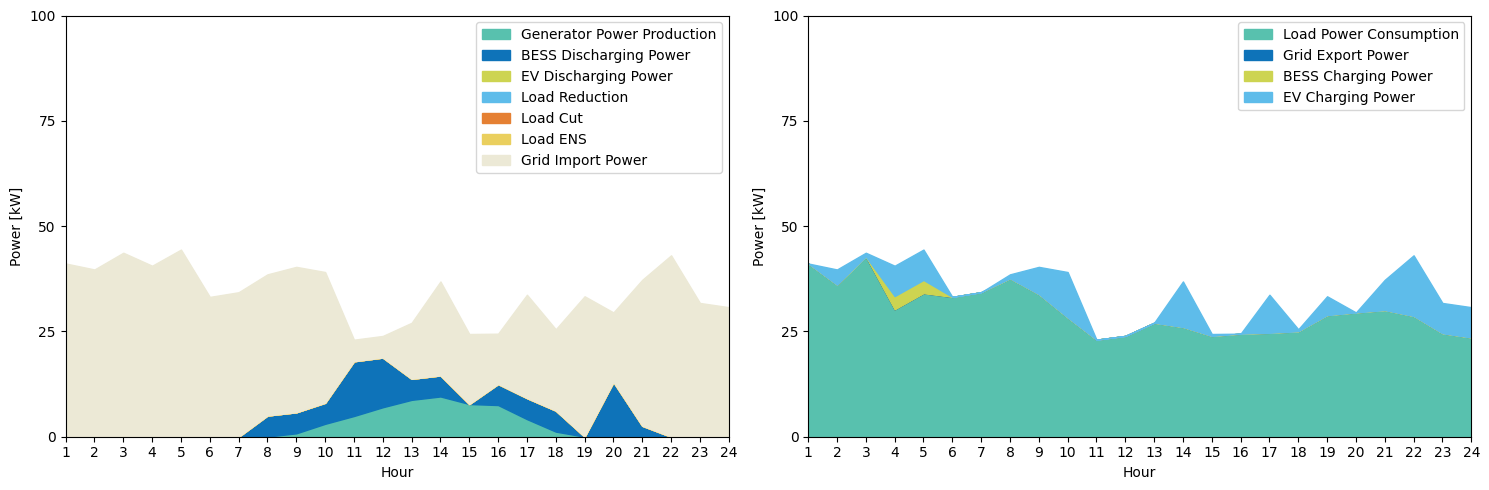

In [17]:

m.plot_profile(result_genActPower=result_genActPower_true_true, result_storDchActPower = result_storDchActPower_true_true,
               result_v2gDchActPower=result_v2gDchActPower_true_true, result_loadRedActPower=result_loadRedActPower_true_true,
               result_loadCutActPower=result_loadCutActPower_true_true, result_loadENS=result_loadENS_true_true,
               result_pimp=result_pimp_true_true, model = model_true_true, Data = True_Data, result_genExcActPower=result_genExcActPower_true_true,
               result_storChActPower=result_storChActPower_true_true, result_v2gChActPower=result_v2gChActPower_true_true,
               save = _save_plots, path=f'plots/no_factors/step2', name = f'measured-{_specific_date}-step-{_time_step}', graph_max=100, graph_step=25)

In [18]:
# This function put on a excel all the data that was ploted on the previous part (plot_profile function)
m.export_profile_to_excel(
    result_genActPower_true_true,
    result_storDchActPower_true_true,
    result_v2gDchActPower_true_true,
    result_loadRedActPower_true_true,
    result_loadCutActPower_true_true,
    result_loadENS_true_true,
    result_pimp_true_true,
    model_true_true,
    True_Data,
    result_genExcActPower_true_true,
    result_storChActPower_true_true,
    result_v2gChActPower_true_true,
    path='./results/no_factors/step2',  
    name='step2_profile_data.xlsx'   
)

# Step 3 - Forecast & Real

In this case, the model runs 24*60 / time_step times. The used inputs can be seen on `inputs_database/my_sql_info`, separated in the directories `generation`, `generation_forecast`, `loads`, `loads_forecast`

In [19]:
#Operation/Control 
# @TODO This cell is giving problems if we do not use the databases input instead of the excel.

all_data = []
all_models = []
results_dict = {}
# results_dict = m.store_results(1, results_dict, result_pimp, result_pexp, result_genActPower, result_genExcActPower, result_genXo, result_loadRedActPower, result_loadCutActPower, result_loadENS, result_loadXo, result_storEnerState, result_storDchActPower, result_storChActPower, result_storDchXo, result_storChXo, result_storScheduleChRelax, result_storScheduleDchRelax, result_v2gChActPower, result_v2gDchActPower, result_v2gEnerState, result_v2gRelax, result_v2gDchXo, result_v2gChXo, result_v2gScheduleChRelax, result_v2gScheduleDchRelax, result_csActPower, result_csActPowerNet)

integral_of_error_gen = np.zeros((5, 1))
integral_of_error_load = np.zeros((5, 1))
forecast_error_load_at_time = True_Data.get_data().load['p_forecast'][:, :] - Data_forecast.get_data().load['p_forecast'][:, :] 
forecast_error_gen_at_time = True_Data.get_data().generator['p_forecast'][:, :] - Data_forecast.get_data().generator['p_forecast'][:, :]

for i in range(1, 24*60//_time_step+1):
    
    print(i)
    #  Result extraction - Saving the results on CSVs:
    folder = f'./results/no_factors/step3/{i}substep'

    if not os.path.exists(folder):
        os.makedirs(folder)

    generation_combination_folder = f'./inputs_database/no_factors/step3/combination_generation/'  
    loads_combination_folder = f'./inputs_database/no_factors/step3/combination_loads'

    integral_of_error_gen = integral_of_error_gen + forecast_error_gen_at_time[:, i-1].reshape(5, 1)
    integral_of_error_load = integral_of_error_load + forecast_error_load_at_time[:, i-1].reshape(5, 1)
    
    #Build the data for each time step with the forecast data and the true data
    Data_at_time = build_data.Data()
    Data_at_time.change_time_step(_time_step)

    Data_at_time.get_gen_forecast_data_from_db(specific_date=_specific_date, experiment_id = 17, start=i, end = 24*60//_time_step, time_step=_time_step, folder=generation_combination_folder)
    Data_at_time.get_gen_data_from_db(specific_date=_specific_date, start=0, end = i, time_step=_time_step, folder=generation_combination_folder)
    
    Data_at_time.get_loads_forecast_data_from_db(specific_date=_specific_date, experiment_id = 23, start=i, end = 24*60//_time_step, time_step=_time_step, folder=loads_combination_folder)
    Data_at_time.get_loads_data_from_db(specific_date=_specific_date, start=0, end = i, time_step=_time_step, folder=loads_combination_folder)

    if _update_forecast:
        Data_at_time.update_forecast_integral(integral_of_error_gen / i , integral_of_error_load / i , i)

    forecast_error_load_at_time = True_Data.get_data().load['p_forecast'][:, :] - Data_at_time.get_data().load['p_forecast'][:, :] 
    forecast_error_gen_at_time = True_Data.get_data().generator['p_forecast'][:, :] - Data_at_time.get_data().generator['p_forecast'][:, :]


    if i != 1:
        #Update the initial state of the storage with the final state of the storage of the previous time step
        Data_at_time.change_initial_state_storage(np.array(results_dict[i-1]['storStateInit'])/Data_at_time.get_data().storage['energy_capacity'])

    all_data.append(Data_at_time)

    # Create the model 
    model_at_time = pe.ConcreteModel()
    model_at_time.t = pe.Set(initialize=np.arange(i, 24*60//_time_step+1),
                 doc='Time periods') 

    model_at_time = m.def_import_export(Data_at_time.get_data(), model_at_time, i=i) #From Excel.
    model_at_time = m.def_gen(Data_at_time.get_data(), model_at_time, i=i) #It can come from Excel or DB.
    model_at_time = m.def_loads(Data_at_time.get_data(), model_at_time, i=i) #It can come from Excel or DB.
    model_at_time = m.def_storage(Data_at_time.get_data(), model_at_time, i=i, 
                            forecast=False, schedule_storageCh=schedule_storageCh, schedule_storageDch=schedule_storageDch) #From Excel.
    model_at_time = m.def_v2g(Data_at_time.get_data(), model_at_time, i=i, #From Excel.
                            forecast=False, schedule_v2gCh=schedule_v2gCh, schedule_v2gDch=schedule_v2gDch) 
    model_at_time = m.def_charging_stations(Data_at_time.get_data(), model_at_time, i=i) #From Excel.
    
    
    model_at_time.balanceEq = pe.Constraint(model_at_time.t, rule=m._balanceEq, doc='Balance equation')

    model_at_time.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                            doc='Objective function')

    model_at_time.write('res_community.lp', io_options={'symbolic_solver_labels': True})

    # Solve the model
    solver_forecast = pe.SolverFactory('cplex', executable=path_to_solver)
    solver_forecast.options['LogFile'] = 'res_community.log'

    results_at_time = solver_forecast.solve(model_at_time)
    # results_at_time.write()
    objective_value = pe.value(model_at_time.objFn)
    # print(f"The value of the objective function is: {objective_value}")
    all_models.append(model_at_time)
    
    
    # Generation
    if not os.path.exists(folder + '/generation/'):
        os.makedirs(folder + '/generation/')

    result_genActPower = ext_pyomo_vals(model_at_time.genActPower)
    result_genActPower.to_csv(folder + '/generation/result_genActPower.csv')

    result_genExcActPower = ext_pyomo_vals(model_at_time.genExcPower)
    result_genExcActPower.to_csv(folder + '/generation/result_genExcActPower.csv')

    # Imports/Exports
    if not os.path.exists(folder + '/power/'):
        os.makedirs(folder + '/power/')

    result_pimp= ext_pyomo_vals(model_at_time.imports)
    result_pimp.to_csv(folder + '/power/result_pimp.csv')

    result_pexp = ext_pyomo_vals(model_at_time.exports)
    result_pexp.to_csv(folder + '/power/result_pexp.csv')

    # Loads
    if not os.path.exists(folder + '/loads/'):
        os.makedirs(folder + '/loads/')

    result_loadRedActPower = ext_pyomo_vals(model_at_time.loadRedActPower)
    result_loadRedActPower.to_csv(folder + '/loads/result_loadRedActPower.csv')

    result_loadCutActPower = ext_pyomo_vals(model_at_time.loadCutActPower)
    result_loadCutActPower.to_csv(folder + '/loads/result_loadCutActPower.csv')

    result_loadENS = ext_pyomo_vals(model_at_time.loadENS)
    result_loadENS.to_csv(folder + '/loads/result_loadENS.csv')

    # Storage
    if not os.path.exists(folder + '/storage/'):
        os.makedirs(folder + '/storage/')

    result_storDchActPower = ext_pyomo_vals(model_at_time.storDischarge)
    result_storDchActPower.to_csv(folder + '/storage/result_storDchActPower.csv')

    result_storChActPower = ext_pyomo_vals(model_at_time.storCharge)
    result_storChActPower.to_csv(folder + '/storage/result_storChActPower.csv')

    result_storEnerState = ext_pyomo_vals(model_at_time.storState)
    result_storEnerState.to_csv(folder + '/storage/result_storEnerState.csv')

    result_storRelax = ext_pyomo_vals(model_at_time.storRelax)
    result_storRelax.to_csv(folder + '/storage/result_storRelax.csv')

    result_storScheduleChRelax = ext_pyomo_vals(model_at_time.storScheduleChRelax)
    result_storScheduleChRelax.to_csv(folder + '/storage/result_storScheduleChRelax.csv')

    result_storScheduleDchRelax = ext_pyomo_vals(model_at_time.storScheduleDchRelax)
    result_storScheduleDchRelax.to_csv(folder + '/storage/result_storScheduleDchRelax.csv')

    # V2G
    if not os.path.exists(folder + '/v2g/'):
        os.makedirs(folder + '/v2g/')
    
    result_v2gDchActPower = ext_pyomo_vals(model_at_time.v2gDischarge)
    result_v2gDchActPower.to_csv(folder + '/v2g/result_v2gDchActPower.csv')

    result_v2gChActPower = ext_pyomo_vals(model_at_time.v2gCharge)
    result_v2gChActPower.to_csv(folder + '/v2g/result_v2gChActPower.csv')

    result_v2gEnerState = ext_pyomo_vals(model_at_time.v2gState)
    result_v2gEnerState.to_csv(folder + '/v2g/result_v2gEnerState.csv')

    result_v2gRelax = ext_pyomo_vals(model_at_time.v2gRelax)
    result_v2gRelax.to_csv(folder + '/v2g/result_v2gRelax.csv')

    result_v2gScheduleChRelax = ext_pyomo_vals(model_at_time.v2gScheduleChRelax)
    result_v2gScheduleChRelax.to_csv(folder + '/v2g/result_v2gScheduleChRelax.csv')

    result_v2gScheduleDchRelax = ext_pyomo_vals(model_at_time.v2gScheduleDchRelax)
    result_v2gScheduleDchRelax.to_csv(folder + '/v2g/result_v2gScheduleDchRelax.csv')

    result_v2gSchedule = ext_pyomo_vals(model_at_time.v2gSchedule)
    result_v2gSchedule.to_csv(folder + '/v2g/result_v2gSchedule.csv')
    
    result_v2gScheduleDepartureSOC = ext_pyomo_vals(model_forecast.v2gScheduleDepartureSOC)
    result_v2gScheduleDepartureSOC.to_csv(folder + '/v2g/result_v2gScheduleDepartureSOC.csv')

    result_v2gState = ext_pyomo_vals(model_at_time.v2gState)
    result_v2gState.to_csv(folder + '/v2g/result_v2gState.csv')

    # Charging Stations
    if not os.path.exists(folder + '/cs/'):
        os.makedirs(folder + '/cs/')
    
    result_csActPower = ext_pyomo_vals(model_at_time.csCharge)
    result_csActPower.to_csv(folder + '/cs/result_csActPower.csv')

    result_csActPowerNet = ext_pyomo_vals(model_at_time.csNetCharge)
    result_csActPowerNet.to_csv(folder + '/cs/result_csActPowerNet.csv')

    # Booleans
    if not os.path.exists(folder + '/bool/'):
        os.makedirs(folder + '/bool/')
    result_genXo = ext_pyomo_vals(model_at_time.genXo)
    result_genXo.to_csv(folder + '/bool/result_genXo.csv')

    result_loadXo = ext_pyomo_vals(model_at_time.loadXo)
    result_loadXo.to_csv(folder + '/bool/result_loadXo.csv')

    result_storDchXo = ext_pyomo_vals(model_at_time.storDchXo)
    result_storDchXo.to_csv(folder + '/bool/result_storDchXo.csv')

    result_storChXo = ext_pyomo_vals(model_at_time.storChXo)
    result_storChXo.to_csv(folder + '/bool/result_storChXo.csv')

    result_v2gDchXo= ext_pyomo_vals(model_at_time.v2gDchXo)
    result_v2gDchXo.to_csv(folder + '/bool/result_v2gDchXo.csv')

    result_v2gChXo = ext_pyomo_vals(model_at_time.v2gChXo)
    result_v2gChXo.to_csv(folder + '/bool/result_v2gChXo.csv')

    with pd.ExcelWriter(folder + '/evs_output.xlsx') as writer:
        result_v2gState.to_excel(writer, sheet_name='v2gState', index=False)
        result_v2gScheduleDepartureSOC.to_excel(writer, sheet_name='v2gScheduleDepartureSOC', index=False)
        result_v2gRelax.to_excel(writer, sheet_name='v2gRelax', index=False)

    # Store results in a dictionary
    results_dict = m.store_results(i, results_dict, result_pimp, result_pexp, result_genActPower, result_genExcActPower,
                                   result_genXo, result_loadRedActPower, result_loadCutActPower, result_loadENS,
                                   result_loadXo, result_storEnerState, result_storDchActPower,
                                   result_storChActPower, result_storDchXo, result_storChXo,
                                   result_storScheduleChRelax, result_storScheduleDchRelax,
                                   result_v2gChActPower, result_v2gDchActPower, result_v2gEnerState,
                                   result_v2gRelax, result_v2gDchXo, result_v2gChXo, result_v2gScheduleChRelax,
                                   result_v2gScheduleDchRelax, result_csActPower, result_csActPowerNet)

    # m.plot_profile(result_genActPower,result_storDchActPower, result_v2gDchActPower,result_loadRedActPower,result_loadCutActPower,
    # result_loadENS,result_pimp, model_at_time,Data_at_time, result_genExcActPower, result_storChActPower, result_v2gChActPower, i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


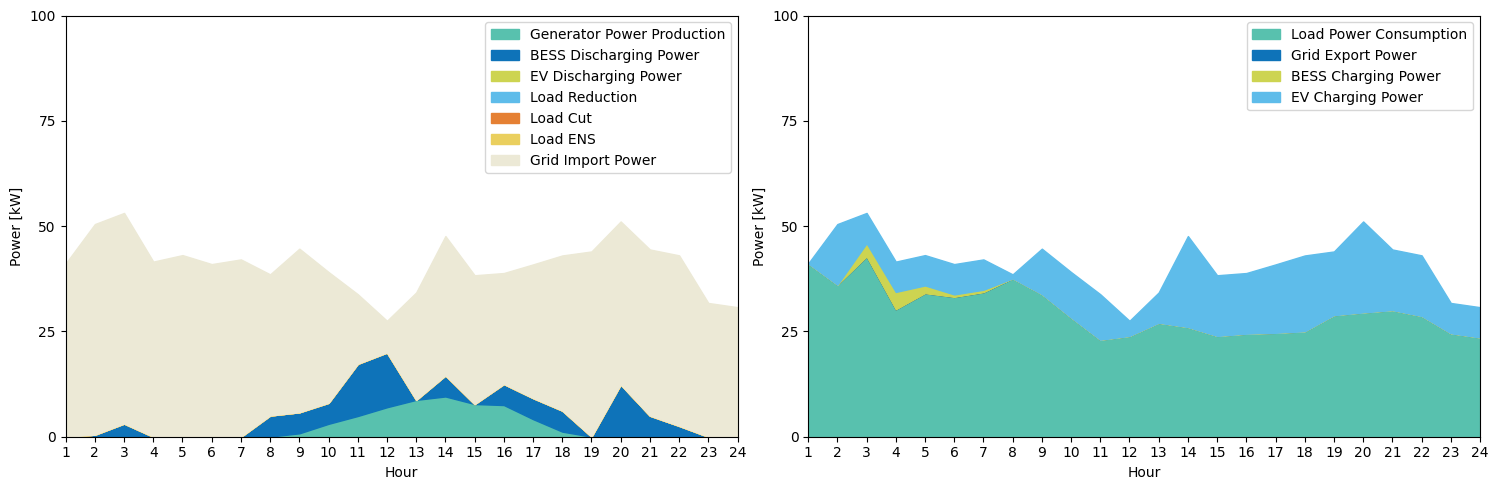

In [20]:
#Plot the operation of the community results

result_genActPower = np.array([results_dict[hour]['genActPowerInit'] for hour in sorted(results_dict.keys())])
result_storDchActPower = np.array([results_dict[hour]['storDischargeInit'] for hour in sorted(results_dict.keys())])
result_v2gDchActPower = np.array([results_dict[hour]['v2gDischargeInit'] for hour in sorted(results_dict.keys())])
result_loadRedActPower = np.array([results_dict[hour]['loadRedActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadCutActPower = np.array([results_dict[hour]['loadCutActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadENS = np.array([results_dict[hour]['loadENSInit'] for hour in sorted(results_dict.keys())])
result_pimp = np.array([results_dict[hour]['importsInit'] for hour in sorted(results_dict.keys())])
result_genExcActPower = np.array([results_dict[hour]['genExcPowerInit'] for hour in sorted(results_dict.keys())])
result_storChActPower = np.array([results_dict[hour]['storChargeInit'] for hour in sorted(results_dict.keys())])
result_v2gChActPower = np.array([results_dict[hour]['v2gChargeInit'] for hour in sorted(results_dict.keys())])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Production
y1_prod = sum([result_genActPower[:, i].astype(float) for i in range(result_genActPower.shape[1])]) 
y2_prod = sum([result_storDchActPower[:,i] for i in range(result_storDchActPower.shape[1])]) 
y3_prod = sum([result_v2gDchActPower[:, i] for i in range(result_v2gDchActPower.shape[1])]) 
y4_prod = sum([result_loadRedActPower[:, i] for i in range(result_loadRedActPower.shape[1])]) 
y5_prod = sum([result_loadCutActPower[:, i] for i in range(result_loadCutActPower.shape[1])])
y6_prod = sum([result_loadENS[:, i] for i in range(result_loadENS.shape[1])]) 

y7_prod = result_pimp.squeeze() 



# Consumption
y1_cons = np.sum(True_Data.get_data().load['p_forecast'][:, 0:24*60//_time_step]*5, axis=0, dtype=np.float64)
y2_cons = sum([result_genExcActPower[:, i] for i in range(result_genExcActPower.shape[1])])
y3_cons = sum([result_storChActPower[:, i] for i in range(result_storChActPower.shape[1])])
y4_cons = sum([result_v2gChActPower[:, i] for i in range(result_v2gChActPower.shape[1])]) 


# Plot production

axs[0].fill_between(list(range(1, len(y1_prod)+1)), np.zeros(len(y1_prod)), y1_prod, color=project_colors_list[0], label="Generator Power Production")
axs[0].fill_between(list(range(1, len(y2_prod)+1)), y1_prod, y1_prod + y2_prod, color=project_colors_list[1], label="BESS Discharging Power")
axs[0].fill_between(list(range(1, len(y3_prod)+1)), y1_prod + y2_prod, y1_prod + y2_prod + y3_prod, color=project_colors_list[2], label="EV Discharging Power")
axs[0].fill_between(list(range(1, len(y4_prod)+1)), y1_prod + y2_prod + y3_prod, y1_prod + y2_prod + y3_prod + y4_prod, color=project_colors_list[3], label="Load Reduction")
axs[0].fill_between(list(range(1, len(y5_prod)+1)), y1_prod + y2_prod + y3_prod + y4_prod, y1_prod + y2_prod + y3_prod + y4_prod + y5_prod, color=project_colors_list[4], label="Load Cut")
axs[0].fill_between(list(range(1, len(y6_prod)+1)), y1_prod + y2_prod + y3_prod + y4_prod + y5_prod, y1_prod + y2_prod + y3_prod + y4_prod + y5_prod + y6_prod, color=project_colors_list[5], label="Load ENS")
axs[0].fill_between(list(range(1, len(y7_prod)+1)), y1_prod + y2_prod + y3_prod + y4_prod + y5_prod + y6_prod, y1_prod + y2_prod + y3_prod + y4_prod + y5_prod + y6_prod + y7_prod, color=project_colors_list[6], label="Grid Import Power")

#@TODO This way, it is automatically formated the graphs:
#axs[0].set_ylim(0, 1.1*max(np.max(y1_prod + y2_prod + y3_prod + y4_prod + y5_prod + y6_prod + y7_prod), np.max(y1_cons + y2_cons + y3_cons + y4_cons)))
graph_max = 100
graph_step = 25

axs[0].set_ylim(0, graph_max)
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(graph_step))

axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Power [kW]')
#axs[0].set_title('Production')
axs[0].legend()

# Plot consumption
axs[1].fill_between(list(range(1, len(y1_cons)+1)), np.zeros(len(y1_cons)), y1_cons, color=project_colors_list[0], label="Load Power Consumption")
axs[1].fill_between(list(range(1, len(y2_cons)+1)), y1_cons, y1_cons + y2_cons, color=project_colors_list[1], label="Grid Export Power")
axs[1].fill_between(list(range(1, len(y3_cons)+1)), y1_cons + y2_cons, y1_cons + y2_cons + y3_cons, color=project_colors_list[2], label="BESS Charging Power")
axs[1].fill_between(list(range(1, len(y4_cons)+1)), y1_cons + y2_cons + y3_cons, y1_cons + y2_cons + y3_cons + y4_cons, color=project_colors_list[3], label="EV Charging Power")



#axs[1].set_ylim(0, 1.1*max(np.max(y1_prod + y2_prod + y3_prod + y4_prod + y5_prod + y6_prod + y7_prod), np.max(y1_cons + y2_cons + y3_cons + y4_cons)))

axs[1].set_ylim(0, graph_max)
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(graph_step))
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Power [kW]')
#axs[1].set_title('Consumption')
axs[1].legend()

axs[0].set_xlim(1, 24*60//_time_step)
axs[1].set_xlim(1, 24*60//_time_step)
plt.tight_layout()
ticks = range(1, 24*60//_time_step + 1)
axs[0].set_xticks(ticks)
axs[1].set_xticks(ticks)
directory = f'plots/no_factors/step3'
filename = f'operation-{_specific_date}-{_update_forecast}-step-{_time_step}.png'
full_path = os.path.join(directory, filename)

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the plot to the specified path
plt.savefig(full_path, dpi=300, bbox_inches='tight')

plt.show()


In [21]:
#Metrics
metric02 = m.metric02(np.array(result_pimp_true_true), np.array(result_pimp), np.array(result_loadRedActPower_true_true), np.array(result_loadRedActPower).T,
           np.array(result_loadCutActPower_true_true), np.array(result_loadCutActPower).T, np.array(result_loadENS_true_true), np.array(result_loadENS).T,
           a = 0.1, b = 0.2, c = 0.5, d = 1)

In [22]:
# Save the metrics to a file
forecast_error_load = np.abs(Data_forecast.get_data().load['p_forecast'][:, :] - True_Data.get_data().load['p_forecast'][:, :])
forecast_error_gen = np.abs(Data_forecast.get_data().generator['p_forecast'][:, :] - True_Data.get_data().generator['p_forecast'][:, :])

dataaaaaa = np.vstack([_specific_date,
                       _update_forecast,
                       np.sum(forecast_error_load, dtype=np.float64).reshape(-1, 1),
                       np.sum(forecast_error_gen, dtype=np.float64).reshape(-1, 1),
                       metric02]).T

df = pd.DataFrame(dataaaaaa, columns=['Date', 'Error propagation', 'Load Error', 'Gen Error', 'Metric02'])

file_path = 'mega_metric_no_factors.xlsx'

print(df)
if os.path.exists(file_path):
        existing_data = pd.read_excel(file_path)
        combined_data = pd.concat([existing_data, df]).drop_duplicates(subset=['Date', 'Error propagation'], keep='first')
else:
    combined_data = df
combined_data.to_excel(file_path, index=False)

         Date Error propagation         Load Error           Gen Error  \
0  2019-11-06             False  48.23995747184753  13.856326732280653   

              Metric02  
0  0.01103671504833748  


# Getting MySQL DBs information and putting on CSVs:


Functions to access the databases:



In [23]:
# Open a connection to db and return a cursor.
def db_open():
    try:
        conn = mysql.connector.connect(
            user="ist1100103",
            password="ozgo1085",
            host="db.tecnico.ulisboa.pt",
            database="ist1100103",
            ssl_disabled=True
        )
        cur = conn.cursor()
        print("Connected!")
        return conn, cur
    except mysql.connector.Error as e:
        print(f"Error connecting to DB Platform: {e}")
        sys.exit(1)

# Retrieve all forecast from db, returning a list.
def db_get_all(cur, table):
    query = f"SELECT * FROM {table}"
    try:
        cur.execute(query)
        return cur.fetchall()
    except mysql.connector.Error as err:
        print(f"Error executing query: {err}")

#Getting all columns titles.
def db_get_all_columns(cur, table):
    query = f"SHOW COLUMNS FROM {table}"
    try:
        cur.execute(query)
        columns = [column[0] for column in cur.fetchall()]
        return columns
    except mysql.connector.Error as err:
        print(f"Error executing query: {err}")



Using above functions:

In [24]:
# Generators DB:

results_folder = "inputs_database/no_factors/my_sql_info"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

connection, cursor = db_open()
print(connection, cursor)
generators = db_get_all(cursor, "generators")
generators_columns = db_get_all_columns(cursor, "generators")

df_generators = pd.DataFrame()

for i in range(len(generators_columns)):
    df_generators[generators_columns[i]] = [value[i] for value in generators]

df_generators.to_csv(results_folder + "/generators.csv")

Connected!
<mysql.connector.connection.MySQLConnection object at 0x7faaa7309d80> MySQLCursor: (Nothing executed yet)


In [25]:
# Generators Forecast DB:

generators_forecast = db_get_all(cursor, "generators_forecast")
generators_forecast_columns = db_get_all_columns(cursor, "generators_forecast")

df_generators_forecast = pd.DataFrame()

for i in range(len(generators_forecast_columns)):
    df_generators_forecast[generators_forecast_columns[i]] = [value[i] for value in generators_forecast]

df_generators_forecast.to_csv(results_folder + "/generators_forecast.csv")

In [26]:
# Loads DB:

loads = db_get_all(cursor, "loads")
loads_columns = db_get_all_columns(cursor, "loads")

df_loads = pd.DataFrame()

for i in range(len(loads_columns)):
    df_loads[loads_columns[i]] = [value[i] for value in loads]

df_loads.to_csv(results_folder + "/loads.csv")

In [27]:
# Loads Forecast DB:

loads_forecast = db_get_all(cursor, "loads_forecast")
loads_forecast_columns = db_get_all_columns(cursor, "loads_forecast")

df_loads_forecast = pd.DataFrame()

for i in range(len(loads_forecast_columns)):
    df_loads_forecast[loads_forecast_columns[i]] = [value[i] for value in loads_forecast]

df_loads_forecast.to_csv(results_folder + "/loads_forecast.csv")